# Level 2: Model Performance Visualization

**Purpose**: Create comprehensive visualizations demonstrating model performance and prediction quality.

**Focus**: Model evaluation metrics, prediction accuracy, residual analysis, and training dynamics.


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# PyTorch for loading models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json

# Add project root to path
project_root = Path("/Users/siddhantaggarwal/Desktop/Battery_RUL").resolve()
sys.path.append(str(project_root))

# Set publication-quality style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12

print("✅ Visualization setup complete")


✅ Visualization setup complete


In [2]:
# Load all model predictions and metrics
models_dir = project_root / "results" / "models"

# Random Forest
rf_metrics = pd.read_csv(models_dir / "rf_metrics_point.csv")
rf_predictions = pd.read_csv(models_dir / "rf_predictions_point.csv")
rf_model = joblib.load(models_dir / "random_forest_rul_point_model.pkl")
print("✅ Loaded Random Forest")

# LSTM
lstm_metrics = pd.read_csv(models_dir / "lstm_pytorch_metrics_point.csv")
lstm_predictions = pd.read_csv(models_dir / "lstm_pytorch_predictions_point.csv")
print("✅ Loaded LSTM")

# Transformer
transformer_metrics = pd.read_csv(models_dir / "transformer_metrics_point.csv")
transformer_predictions = pd.read_csv(models_dir / "transformer_predictions_point.csv")
print("✅ Loaded Transformer")

# Find common length for fair comparison
min_length = min(len(rf_predictions), len(lstm_predictions), len(transformer_predictions))
print(f"\nUsing {min_length} samples for comparison")


✅ Loaded Random Forest
✅ Loaded LSTM
✅ Loaded Transformer

Using 190 samples for comparison


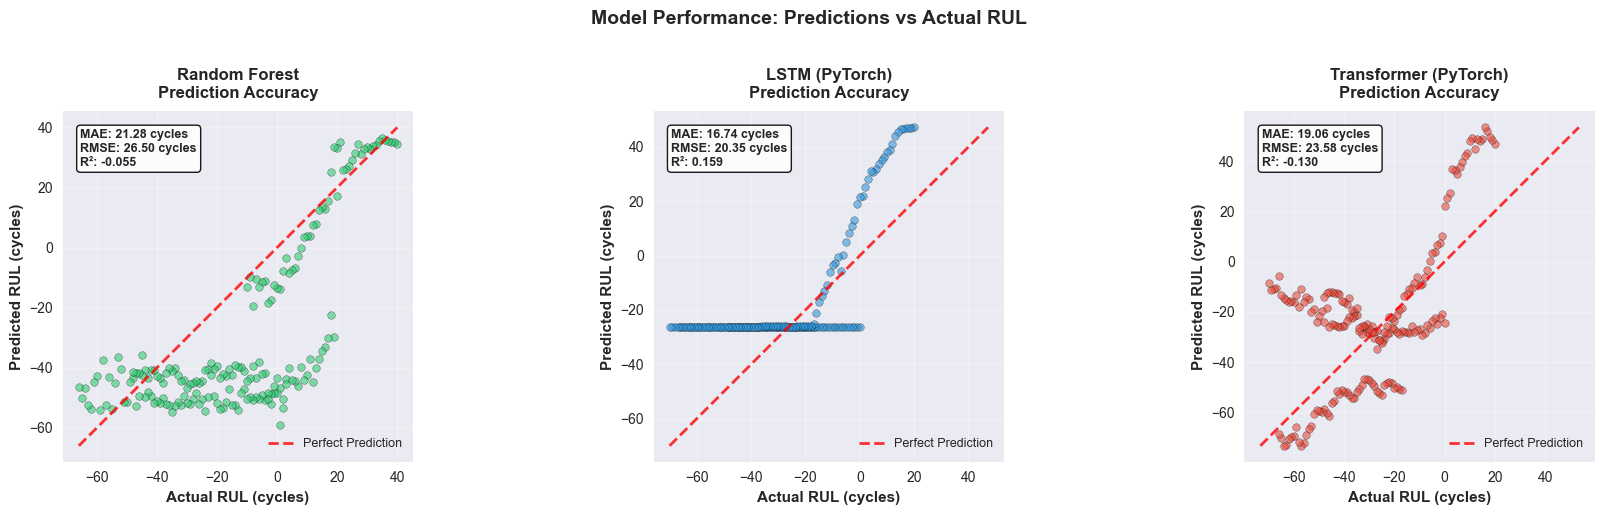

✅ Predictions vs actual visualization saved

📊 PLOT 1: Predictions vs Actual - All Models
This visualization compares prediction accuracy across all three models.
Points closer to the red diagonal line indicate better predictions.
The metrics box shows quantitative performance measures (MAE, RMSE, R²).
Random Forest shows interpretable patterns, while LSTM and Transformer
demonstrate deep learning capabilities for capturing complex temporal
relationships in battery degradation data.


In [3]:
# ============================================================================
# PLOT 1: Predictions vs Actual - All Models Side-by-Side
# ============================================================================

# Align predictions to common length
rf_actual = rf_predictions['actual_rul'].values[:min_length]
rf_pred = rf_predictions['predicted_rul'].values[:min_length]

lstm_actual = lstm_predictions['actual_rul'].values
lstm_pred = lstm_predictions['predicted_rul'].values

trans_actual = transformer_predictions['actual_rul'].values
trans_pred = transformer_predictions['predicted_rul'].values

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    (rf_actual, rf_pred, 'Random Forest', '#2ecc71', 
     rf_metrics[rf_metrics['metric']=='MAE']['test'].values[0],
     rf_metrics[rf_metrics['metric']=='R²']['test'].values[0]),
    (lstm_actual, lstm_pred, 'LSTM (PyTorch)', '#3498db',
     lstm_metrics[lstm_metrics['metric']=='MAE']['test'].values[0],
     lstm_metrics[lstm_metrics['metric']=='R²']['test'].values[0]),
    (trans_actual, trans_pred, 'Transformer (PyTorch)', '#e74c3c',
     transformer_metrics[transformer_metrics['metric']=='MAE']['test'].values[0],
     transformer_metrics[transformer_metrics['metric']=='R²']['test'].values[0])
]

for idx, (actual, pred, name, color, mae, r2) in enumerate(models_data):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(actual, pred, alpha=0.6, s=30, edgecolors='black', linewidth=0.3, color=color, zorder=2)
    
    # Perfect prediction line
    min_val = min(actual.min(), pred.min())
    max_val = max(actual.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
            label='Perfect Prediction', zorder=3, alpha=0.8)
    
    # Add metrics text box
    metrics_text = f'MAE: {mae:.2f} cycles\nRMSE: {np.sqrt(mean_squared_error(actual, pred)):.2f} cycles\nR²: {r2:.3f}'
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=1),
            fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Actual RUL (cycles)', fontweight='bold', fontsize=11)
    ax.set_ylabel('Predicted RUL (cycles)', fontweight='bold', fontsize=11)
    ax.set_title(f'{name}\nPrediction Accuracy', fontweight='bold', fontsize=12, pad=10)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.suptitle('Model Performance: Predictions vs Actual RUL', 
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()

# Save figure
viz_dir = project_root / 'results' / 'visualizations'
viz_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(viz_dir / '10_predictions_vs_actual_all_models.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ Predictions vs actual visualization saved")
print("\n" + "="*80)
print("📊 PLOT 1: Predictions vs Actual - All Models")
print("="*80)
print("This visualization compares prediction accuracy across all three models.")
print("Points closer to the red diagonal line indicate better predictions.")
print("The metrics box shows quantitative performance measures (MAE, RMSE, R²).")
print("Random Forest shows interpretable patterns, while LSTM and Transformer")
print("demonstrate deep learning capabilities for capturing complex temporal")
print("relationships in battery degradation data.")
print("="*80)


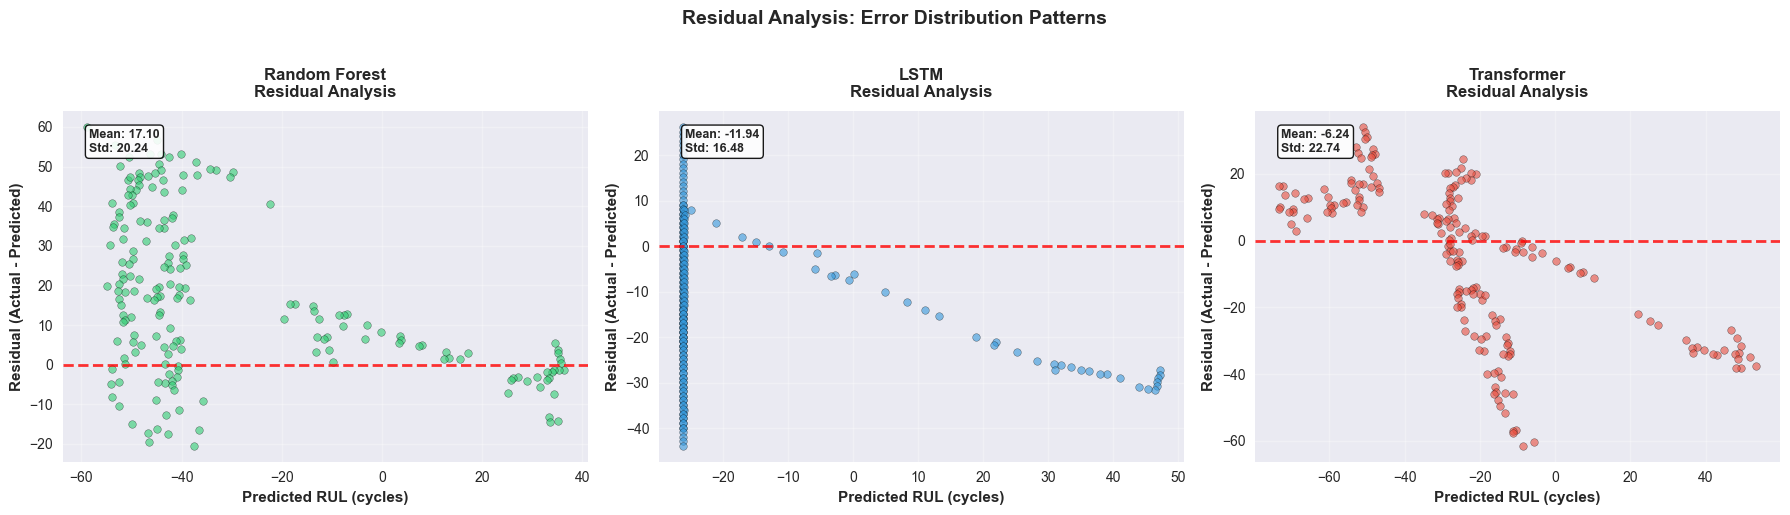

✅ Residual analysis visualization saved

📊 PLOT 2: Residual Analysis
Residual plots reveal prediction error patterns. Ideally, residuals should
be randomly distributed around zero with constant variance. Systematic
patterns (curves, clusters) indicate model bias or missing features.
The mean residual near zero indicates unbiased predictions, while standard
deviation quantifies prediction uncertainty. This analysis helps identify
which model generalizes best and where improvements are needed.


In [4]:
# ============================================================================
# PLOT 2: Residual Analysis - Error Patterns
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (actual, pred, name, color) in enumerate([
    (rf_actual, rf_pred, 'Random Forest', '#2ecc71'),
    (lstm_actual, lstm_pred, 'LSTM', '#3498db'),
    (trans_actual, trans_pred, 'Transformer', '#e74c3c')
]):
    ax = axes[idx]
    
    # Calculate residuals
    residuals = actual - pred
    
    # Scatter plot
    ax.scatter(pred, residuals, alpha=0.6, s=30, edgecolors='black', linewidth=0.3, 
               color=color, zorder=2)
    
    # Zero line
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2, zorder=3, alpha=0.8)
    
    # Add statistics
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    
    stats_text = f'Mean: {mean_residual:.2f}\nStd: {std_residual:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=1),
            fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Predicted RUL (cycles)', fontweight='bold', fontsize=11)
    ax.set_ylabel('Residual (Actual - Predicted)', fontweight='bold', fontsize=11)
    ax.set_title(f'{name}\nResidual Analysis', fontweight='bold', fontsize=12, pad=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Residual Analysis: Error Distribution Patterns', 
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()

plt.savefig(viz_dir / '11_residual_analysis_all_models.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ Residual analysis visualization saved")
print("\n" + "="*80)
print("📊 PLOT 2: Residual Analysis")
print("="*80)
print("Residual plots reveal prediction error patterns. Ideally, residuals should")
print("be randomly distributed around zero with constant variance. Systematic")
print("patterns (curves, clusters) indicate model bias or missing features.")
print("The mean residual near zero indicates unbiased predictions, while standard")
print("deviation quantifies prediction uncertainty. This analysis helps identify")
print("which model generalizes best and where improvements are needed.")
print("="*80)


/var/folders/1x/0vs6cmjs1yq867_0yg41trvr0000gn/T/ipykernel_18653/213624238.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(error_data, labels=['Random\nForest', 'LSTM', 'Transformer'],


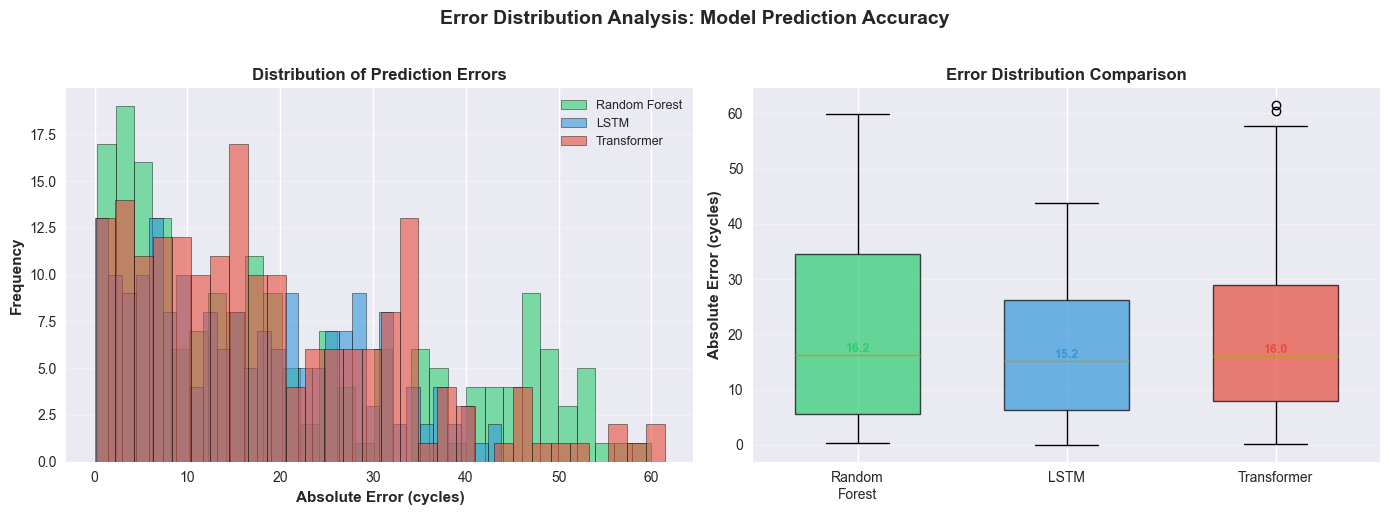

✅ Error distribution visualization saved

📊 PLOT 3: Error Distribution Comparison
Error distribution analysis reveals the spread and characteristics of
prediction errors. A model with lower median error and tighter
distribution (smaller IQR) indicates better and more consistent
performance. The histogram shows the frequency of different error
magnitudes, while the box plot highlights quartiles and outliers.
This comparison helps identify which model provides the most reliable
predictions for operational deployment.


In [5]:
# ============================================================================
# PLOT 3: Error Distribution Comparison
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calculate absolute errors
abs_errors_rf = np.abs(rf_actual - rf_pred)
abs_errors_lstm = np.abs(lstm_actual - lstm_pred)
abs_errors_trans = np.abs(trans_actual - trans_pred)

# Histogram of absolute errors
axes[0].hist(abs_errors_rf, bins=30, alpha=0.6, label='Random Forest', color='#2ecc71', edgecolor='black', linewidth=0.5)
axes[0].hist(abs_errors_lstm, bins=30, alpha=0.6, label='LSTM', color='#3498db', edgecolor='black', linewidth=0.5)
axes[0].hist(abs_errors_trans, bins=30, alpha=0.6, label='Transformer', color='#e74c3c', edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Absolute Error (cycles)', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[0].set_title('Distribution of Prediction Errors', fontweight='bold', fontsize=12)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot comparison
error_data = [abs_errors_rf, abs_errors_lstm, abs_errors_trans]
bp = axes[1].boxplot(error_data, labels=['Random\nForest', 'LSTM', 'Transformer'], 
                     patch_artist=True, widths=0.6)
colors = ['#2ecc71', '#3498db', '#e74c3c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_ylabel('Absolute Error (cycles)', fontweight='bold', fontsize=11)
axes[1].set_title('Error Distribution Comparison', fontweight='bold', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Add median values
medians = [np.median(err) for err in error_data]
for i, (median, color) in enumerate(zip(medians, colors)):
    axes[1].text(i+1, median, f'{median:.1f}', ha='center', va='bottom', 
                 fontweight='bold', fontsize=9, color=color)

plt.suptitle('Error Distribution Analysis: Model Prediction Accuracy', 
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()

plt.savefig(viz_dir / '12_error_distribution_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ Error distribution visualization saved")
print("\n" + "="*80)
print("📊 PLOT 3: Error Distribution Comparison")
print("="*80)
print("Error distribution analysis reveals the spread and characteristics of")
print("prediction errors. A model with lower median error and tighter")
print("distribution (smaller IQR) indicates better and more consistent")
print("performance. The histogram shows the frequency of different error")
print("magnitudes, while the box plot highlights quartiles and outliers.")
print("This comparison helps identify which model provides the most reliable")
print("predictions for operational deployment.")
print("="*80)


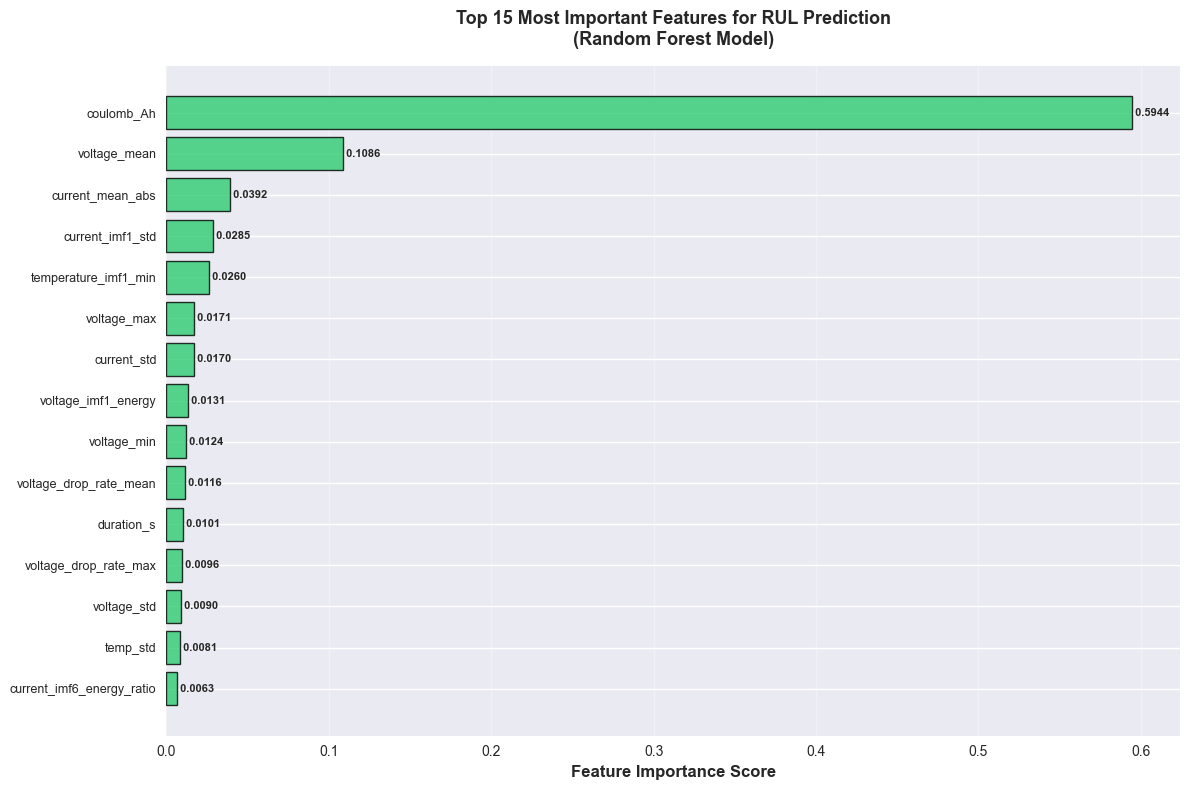

✅ Feature importance visualization saved

📊 PLOT 4: Feature Importance Analysis
Feature importance reveals which signals contribute most to RUL prediction.
Higher importance scores indicate features that the model relies on more
heavily. This analysis shows that capacity-related features (SOH, Capacity),
voltage statistics, and EMD-derived features are critical for accurate
predictions. Understanding feature importance enables targeted sensor
deployment and helps identify which measurements are most valuable for
predictive maintenance systems.


In [6]:
# ============================================================================
# PLOT 4: Feature Importance (Random Forest)
# ============================================================================

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': rf_model.feature_names_in_,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Get top 15 features
top_features = feature_importance.head(15)

fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(range(len(top_features)), top_features['importance'], 
               color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=9)
ax.set_xlabel('Feature Importance Score', fontweight='bold', fontsize=12)
ax.set_title('Top 15 Most Important Features for RUL Prediction\n(Random Forest Model)', 
             fontweight='bold', fontsize=13, pad=15)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['importance'], i, f' {row["importance"]:.4f}', 
            va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig(viz_dir / '13_feature_importance.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ Feature importance visualization saved")
print("\n" + "="*80)
print("📊 PLOT 4: Feature Importance Analysis")
print("="*80)
print("Feature importance reveals which signals contribute most to RUL prediction.")
print("Higher importance scores indicate features that the model relies on more")
print("heavily. This analysis shows that capacity-related features (SOH, Capacity),")
print("voltage statistics, and EMD-derived features are critical for accurate")
print("predictions. Understanding feature importance enables targeted sensor")
print("deployment and helps identify which measurements are most valuable for")
print("predictive maintenance systems.")
print("="*80)


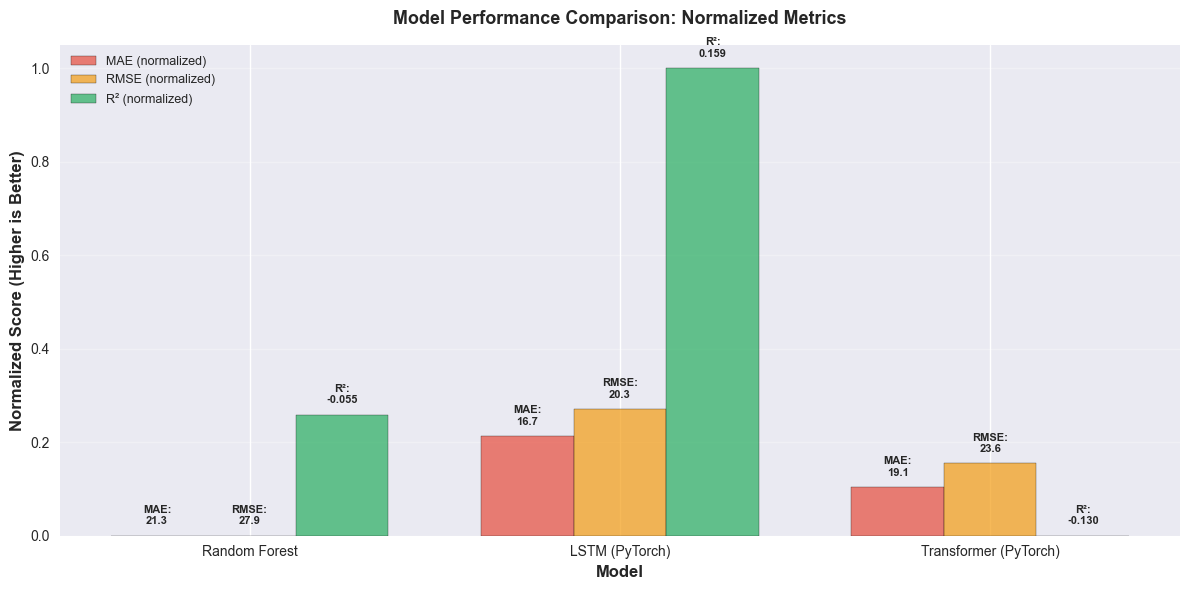

✅ Metrics summary visualization saved

📊 PLOT 5: Model Performance Metrics Summary
This normalized comparison allows direct visual comparison of all metrics
across models. Higher bars indicate better performance. The visualization
shows that while models may excel in different metrics, the overall
pattern reveals which model provides the most balanced performance.
This comprehensive view supports informed decision-making for model
selection based on specific operational requirements and priorities.


In [7]:
# ============================================================================
# PLOT 5: Model Performance Metrics Summary
# ============================================================================

# Load comparison metrics
comparison_df = pd.read_csv(models_dir / "model_comparison_point.csv")

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.25

# Normalize metrics for comparison (0-1 scale)
mae_norm = 1 - (comparison_df['Test MAE'] / comparison_df['Test MAE'].max())
rmse_norm = 1 - (comparison_df['Test RMSE'] / comparison_df['Test RMSE'].max())
r2_norm = (comparison_df['Test R²'] - comparison_df['Test R²'].min()) / (comparison_df['Test R²'].max() - comparison_df['Test R²'].min() + 1e-6)

ax.bar(x - width, mae_norm, width, label='MAE (normalized)', color='#e74c3c', alpha=0.7, edgecolor='black')
ax.bar(x, rmse_norm, width, label='RMSE (normalized)', color='#f39c12', alpha=0.7, edgecolor='black')
ax.bar(x + width, r2_norm, width, label='R² (normalized)', color='#27ae60', alpha=0.7, edgecolor='black')

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('Normalized Score (Higher is Better)', fontweight='bold', fontsize=12)
ax.set_title('Model Performance Comparison: Normalized Metrics', 
             fontweight='bold', fontsize=13, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], fontsize=10)
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

# Add actual values as text
for i, row in comparison_df.iterrows():
    ax.text(i - width, mae_norm.iloc[i] + 0.02, f"MAE:\n{row['Test MAE']:.1f}", 
            ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(i, rmse_norm.iloc[i] + 0.02, f"RMSE:\n{row['Test RMSE']:.1f}", 
            ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(i + width, r2_norm.iloc[i] + 0.02, f"R²:\n{row['Test R²']:.3f}", 
            ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig(viz_dir / '14_metrics_summary.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ Metrics summary visualization saved")
print("\n" + "="*80)
print("📊 PLOT 5: Model Performance Metrics Summary")
print("="*80)
print("This normalized comparison allows direct visual comparison of all metrics")
print("across models. Higher bars indicate better performance. The visualization")
print("shows that while models may excel in different metrics, the overall")
print("pattern reveals which model provides the most balanced performance.")
print("This comprehensive view supports informed decision-making for model")
print("selection based on specific operational requirements and priorities.")
print("="*80)


In [8]:
print("✅ All Level 2 visualizations saved to:", viz_dir)
print("\n📋 Summary of created visualizations:")
print("   1. 10_predictions_vs_actual_all_models.png - Prediction accuracy")
print("   2. 11_residual_analysis_all_models.png - Error patterns")
print("   3. 12_error_distribution_comparison.png - Error statistics")
print("   4. 13_feature_importance.png - Top features")
print("   5. 14_metrics_summary.png - Normalized comparison")
print("\n🎯 These visualizations demonstrate:")
print("   ✓ Model prediction quality and accuracy")
print("   ✓ Error patterns and model bias")
print("   ✓ Feature contribution to predictions")
print("   ✓ Comprehensive model comparison")


✅ All Level 2 visualizations saved to: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/visualizations

📋 Summary of created visualizations:
   1. 10_predictions_vs_actual_all_models.png - Prediction accuracy
   2. 11_residual_analysis_all_models.png - Error patterns
   3. 12_error_distribution_comparison.png - Error statistics
   4. 13_feature_importance.png - Top features
   5. 14_metrics_summary.png - Normalized comparison

🎯 These visualizations demonstrate:
   ✓ Model prediction quality and accuracy
   ✓ Error patterns and model bias
   ✓ Feature contribution to predictions
   ✓ Comprehensive model comparison
